# DPConCFil Manual 2D

### This manual mainly introduce the usage of DPConCFil for 2D data. 

#### Please see `DPConCFil_Manual.ipynb` for more details.

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from astropy import units as u
from collections import defaultdict

import sys

sys.path.append('../')
sys.path.append('../DPConCFil_2D_Code/')


In [46]:
from DPConCFil_2D_Code.Clump_Class import *
from DPConCFil_2D_Code.Filament_Class import *
import DPConCFil_2D_Code.Plot_and_Save_Funs as Plot_and_Save_Funs
import DPConCFil_2D_Code.Profile_Funs as Profile_Funs

In [17]:
file_example = 'Example_Fil_Sum'
file_name = '../Example_Files/Data/Example_Fil_13CO_Sum.fits'
# file_name = '../Example_Files/Data/Example_M16_Fil_13CO_Sum.fits'

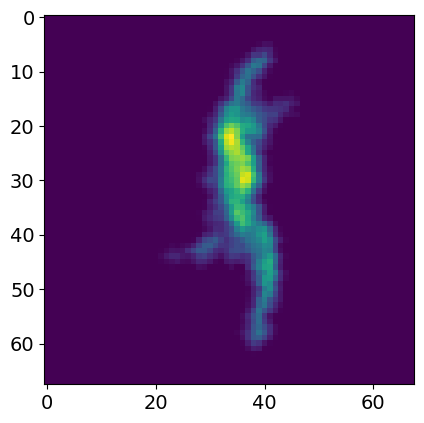

In [18]:
real_data = fits.getdata(file_name)
plt.imshow(real_data)
plt.show()

In [19]:
SWindow = 3 # [3,5,7]
KBins = 35 # [10,...,60]
FwhmBeam = 2
VeloRes = 2
SRecursionLBV = [16, 5] # [(2+FwhmBeam)**2,3+VeloRes]

header = fits.getheader(file_name)
# RMS = header['RMS']
RMS = 0.2
Threshold = 5 * RMS

parameters_FacetClumps = [RMS, Threshold, SWindow, KBins, FwhmBeam, VeloRes, SRecursionLBV]

In [20]:
mask_name = '../Example_Files/Clump/mask_{}.fits'.format(file_example)
outcat_name = '../Example_Files/Clump/outcat_{}.csv'.format(file_example)
outcat_wcs_name = '../Example_Files/Clump/outcat_wcs_{}.csv'.format(file_example)

In [21]:
clumpsObj = ClumpInfor(file_name,mask_name,outcat_name,outcat_wcs_name)

### Calculate the clump information from FacetClumps. 

In this case, the parameters of FacetClumps is essential. More clump detection algorithms can also be added to this process. 

The angle of the clumps detected by FacetClumps is obtained by diagonalizing the moment of inertia matrix, please the article of [FacetClumps](https://iopscience.iop.org/article/10.3847/1538-4365/acda89) for more details. Performing a two-dimensional single Gaussian fitting on the velocity integrated map of a clump can provide more accurate position and direction information of the clump in spatial direction. 

When 'fit_flag=True', it indicates that the fitting will be used. This will benefit the performance of DPConFil.

In [22]:
clumpsObj.Cal_Infor_From_Mask_Or_Algorithm(mask_or_algorithm='FacetClumps',parameters=parameters_FacetClumps)
clumpsObj.Get_Clumps_Infor(fit_flag = True)

100%|██████████| 1/1 [00:00<00:00, 457.44it/s]


Number: 6
Time: 0.09


100%|██████████| 6/6 [00:00<00:00, 152.10it/s]

Fitting Clumps Time: 0.04


In [23]:
clumpsObj.Cal_Infor_From_Mask_Or_Algorithm(mask_or_algorithm='mask')
clumpsObj.Get_Clumps_Infor(fit_flag = True)

Number: 6
Time: 0.02


100%|██████████| 6/6 [00:00<00:00, 150.46it/s]

Fitting Clumps Time: 0.04


Plot the original image. If save_path=None, the image will not be saved.

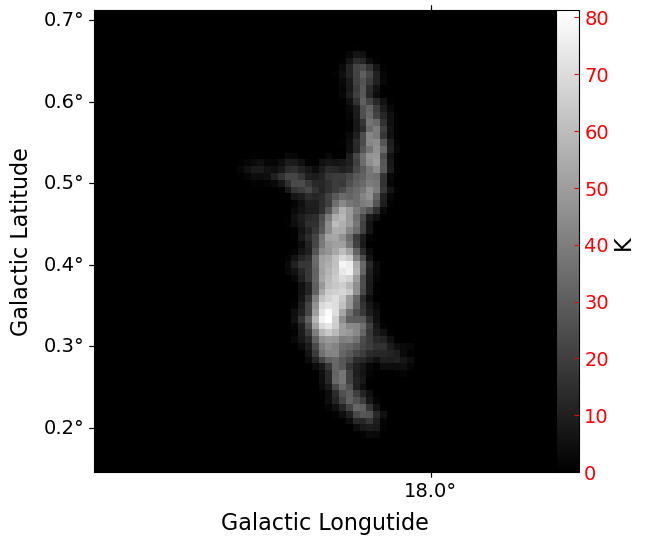

In [24]:
save_path = '../Images/Example_Data.pdf'
Plot_and_Save_Funs.Plot_Origin_Data(clumpsObj,figsize=(8,6),fontsize=16,spacing=60*u.arcmin,save_path=None)

In [25]:
edges = clumpsObj.edges
print('Total number:',len(edges))
print('NO edges number:',np.where(edges==0)[0].shape[0])

Total number: 6
NO edges number: 6


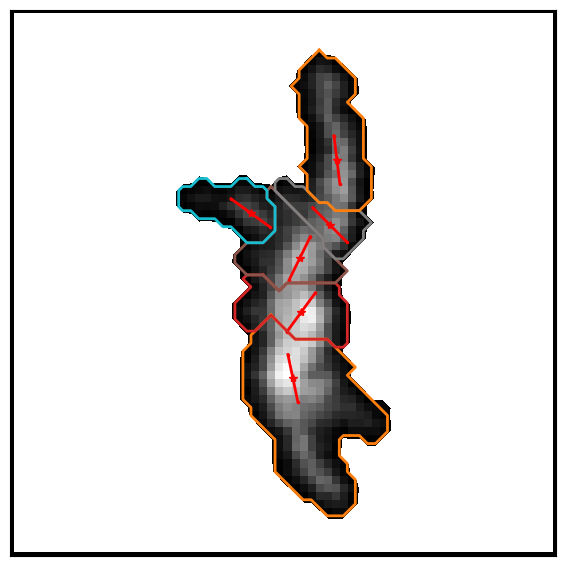

In [26]:
save_path = '../Images/Clumps_Infor.pdf'
Plot_and_Save_Funs.Plot_Clumps_Infor(clumpsObj,figsize=(8,6),line_scale=3,save_path=None)

In [27]:
filament_centers_LB = []
max_path_record = []
max_edges_record = []

data_wcs = clumpsObj.data_wcs
origin_data = clumpsObj.origin_data
regions_data = clumpsObj.regions_data
centers = clumpsObj.centers
connected_ids_dict = clumpsObj.connected_ids_dict

filament_clumps_id = np.int64(np.linspace(0,len(clumpsObj.centers)-1,len(clumpsObj.centers)))

for index in filament_clumps_id:
    filament_centers_LB.append([centers[index][1],centers[index][0]])
filament_centers_LB = np.array(filament_centers_LB)
filament_clumps_id = np.array(filament_clumps_id)

filament_mask_2D = regions_data
Graph,Tree = FCFA.Graph_Infor_SubStructure(origin_data,filament_mask_2D,filament_centers_LB,\
                                           filament_clumps_id,connected_ids_dict)

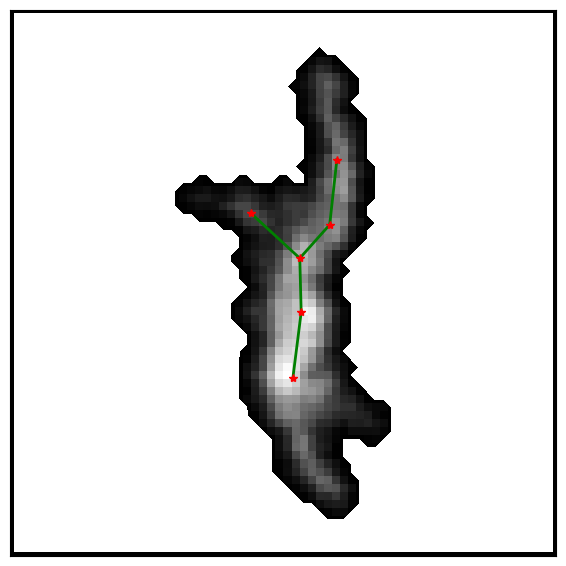

In [28]:
fig, ax0 = plt.subplots(1,1,figsize=(8, 6))
for edge in Tree.edges:
    ax0.plot([filament_centers_LB[edge[0]][0],filament_centers_LB[edge[1]][0]], \
             [filament_centers_LB[edge[0]][1],filament_centers_LB[edge[1]][1]],\
             'green', label='fit', lw=2, alpha=1.0, markersize = 8.)
for filament_center_LB in filament_centers_LB:
    ax0.plot(filament_center_LB[0],filament_center_LB[1],'r*')
    
ax0.imshow(origin_data,
               origin='lower',
               cmap='gray',
               interpolation='none')
ax0.contourf(origin_data,
             levels = [0., .01],
             colors = 'w')

fig.tight_layout()
plt.xticks([]),plt.yticks([])
plt.show()

In [29]:
TolAngle = 30
TolDistance = 4
LBRatio = 2.5
SkeletonType = 'Intensity' #Morphology, Intensity

parameters_DPConFil = [TolAngle,TolDistance,LBRatio]

In [31]:
file_index = 1
file_lines = ['12CO','13CO','C18O']
file_line = file_lines[1]

filament_mask_name = '../Example_Files/Filament/Mask_{}_{}.fits'.format(file_index,file_line)
filament_table_pix_name = '../Example_Files/Filament/Table_Pix_{}_{}.csv'.format(file_index,file_line)
filament_table_wcs_name = '../Example_Files/Filament/Table_WCS_{}_{}.csv'.format(file_index,file_line)
filament_infor_name = '../Example_Files/Filament/Infor_{}_{}'.format(file_index,file_line)

save_files = [filament_mask_name,filament_table_pix_name,filament_table_wcs_name,filament_infor_name]

## DPConFil: Simplified Process

We demonstrate the simplified process of identifying and analyzing filaments using all the sub-methods of `DPConCFil`. 

Construct filament objects. 

In [32]:
filamentObj = FilamentInfor(clumpsObj,parameters_DPConFil,save_files,SkeletonType)

By using the function `Filament_Detect`, we can directly obtain information about the connection between filaments and clumps, as well as the regions and tables associated with the filaments, among other things.

In [33]:
filament_infor_all,Filament_Table_Pix,Filament_Table_WCS = filamentObj.Filament_Detect()

related_ids = filament_infor_all['related_ids']
print('Filament Keys:',list(related_ids.keys()))

print('Filament_Table_Pix:\n',Filament_Table_Pix)
print('Filament_Table_WCS:\n',Filament_Table_WCS)

100%|██████████| 1/1 [00:00<00:00,  2.31it/s]

Number: 1
Time: 0.45
Filament Keys: [0]
Filament_Table_Pix:
  ID  CenL   CenB  Length Area LWRatio Angle Clumps
     pix    pix    pix   pix           deg        
--- ------ ------ ------ ---- ------- ----- ------
  1 27.034 35.755     41  471    3.40 89.94      4
Filament_Table_WCS:
  ID  CenL   CenB Length   Area  LWRatio Angle Clumps
     deg    deg  arcmin arcmin2          deg        
--- ------ ----- ------ ------- ------- ----- ------
  1 18.110 0.375  20.50  117.75    3.40 89.94      4


The performance of the consistency-based identification method in two-dimensional data is suboptimal with the default parameters.

Further analysis can be conducted using the provided clump-filament relationship dictionary `related_ids`.

In [34]:
filament_clumps_id = np.int64(np.linspace(0,len(clumpsObj.centers)-1,len(clumpsObj.centers)))
related_ids = {}
related_ids[0] = list(filament_clumps_id)
filamentObj.related_ids = related_ids

In [35]:
filament_infor_all,Filament_Table_Pix,Filament_Table_WCS = filamentObj.Filament_Detect(related_ids)

related_ids = filament_infor_all['related_ids']
print('Filament Keys:',list(related_ids.keys()))

print('Filament_Table_Pix:\n',Filament_Table_Pix)
print('Filament_Table_WCS:\n',Filament_Table_WCS)

100%|██████████| 1/1 [00:01<00:00,  1.33s/it]

Number: 1
Time: 1.33
Filament Keys: [0]
Filament_Table_Pix:
  ID  CenL   CenB  Length Area LWRatio Angle Clumps
     pix    pix    pix   pix           deg        
--- ------ ------ ------ ---- ------- ----- ------
  1 31.097 36.134     55  667    4.66 86.12      6
Filament_Table_WCS:
  ID  CenL   CenB Length   Area  LWRatio Angle Clumps
     deg    deg  arcmin arcmin2          deg        
--- ------ ----- ------ ------- ------- ----- ------
  1 18.107 0.409  27.50  166.75    4.66 86.12      6


In [36]:
ShowId = 0
SampInt = 2
Substructure = True

filament_clumps_id = related_ids[ShowId]
filamentObj.Filament_Infor_I(filament_clumps_id)

In [37]:
filament_coords = filamentObj.filament_coords
print('The volume of the filament:',len(filament_coords[:,0]))

The volume of the filament: 667


show_id: 0
length: 6


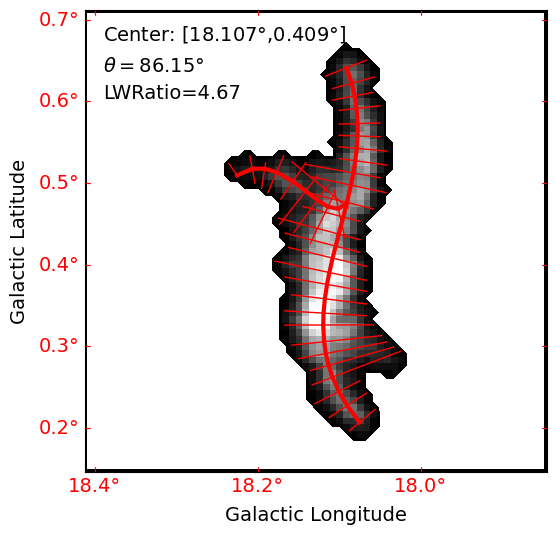

In [38]:
for show_id in related_ids.keys():
    print('show_id:',show_id)
    filament_clumps_id = related_ids[show_id]
    print('length:',len(filament_clumps_id))
    filamentObj.Filament_Infor_I(filament_clumps_id)
    fil_image = filamentObj.filament_data.sum(0)
    
    dictionary_cuts = defaultdict(list)
    dictionary_cuts = filamentObj.Get_Item_Dictionary_Cuts(filament_clumps_id,dictionary_cuts,SampInt,Substructure)
    
    save_path = '../Images/Filament_Fit_Spine_{}'.format(index)
    Plot_and_Save_Funs.Plot_Filament_Item(filamentObj,figsize=(8,6),fontsize=14,spacing=12*u.arcmin,save_path=None)

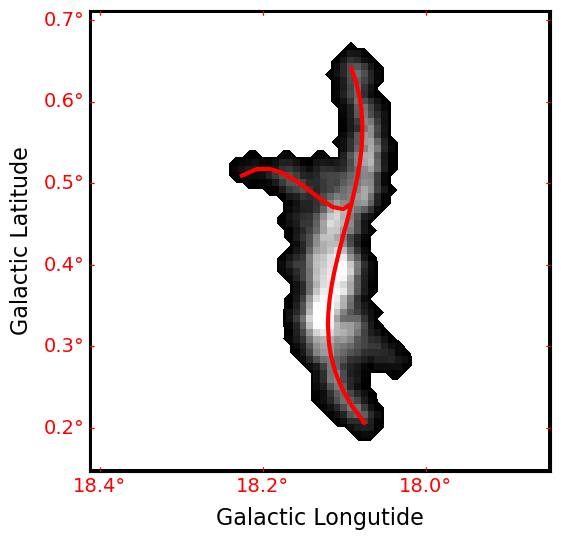

Time: 2.9


In [39]:
start_1 = time.time()

save_path = 'All'

dictionary_cuts = defaultdict(list)
for show_id in related_ids.keys():
    filament_clumps_id = related_ids[show_id]
    filamentObj.Filament_Infor_I(filament_clumps_id)
    dictionary_cuts = filamentObj.Get_Item_Dictionary_Cuts(filament_clumps_id,dictionary_cuts,SampInt,Substructure)
    
Plot_and_Save_Funs.Plot_Filament(filamentObj,figsize=(8,6),fontsize=16,spacing=12*u.arcmin,save_path=None)

end_1 = time.time()
delta_time = np.around(end_1 - start_1, 2)
print('Time:', delta_time)

In [40]:
EProfileTime = 3
EProfileLen = 6
ExtendRange = 20
MeanProfile = True

In [41]:
Profile_Funs.Cal_Mean_Profile(filamentObj,EProfileTime,EProfileLen,ExtendRange)
Profile_Funs.Cal_Profile_IOU(filamentObj)

profile_IOU = filamentObj.profile_IOU
print('profile_IOU:',profile_IOU)

profile_IOU: 0.76


In [42]:
Profile_Funs.Construct_radObj(filamentObj)

==== Gaussian ====
amplitude: 3.793E+01
mean: 0.000
width: 2.854
The statistical uncertainty on the best-fit amplitude is 1.358
The statistical uncertainty on the best-fit mean is 0.147
==== Plummer-like ====
amplitude: 4.257E+01
p: 2.197
R_flat: -1.812
The statistical uncertainty on the best-fit amplitude is 1.971
The statistical uncertainty on the best-fit powerIndex is 0.299
The statistical uncertainty on the best-fit flatteningRadius is 0.482


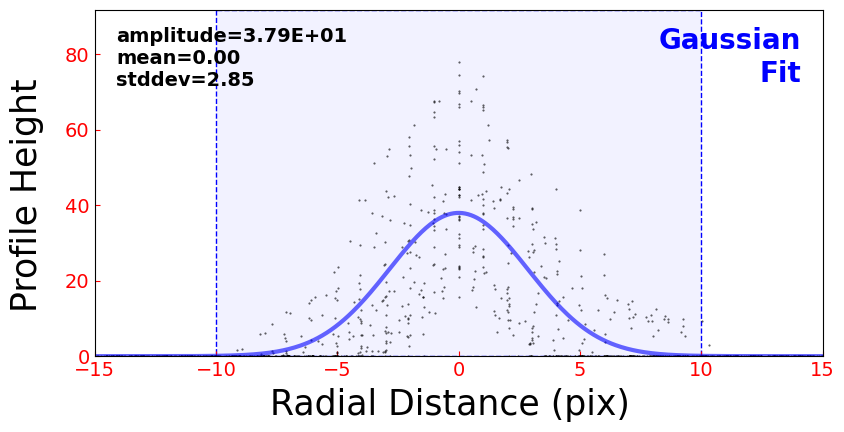

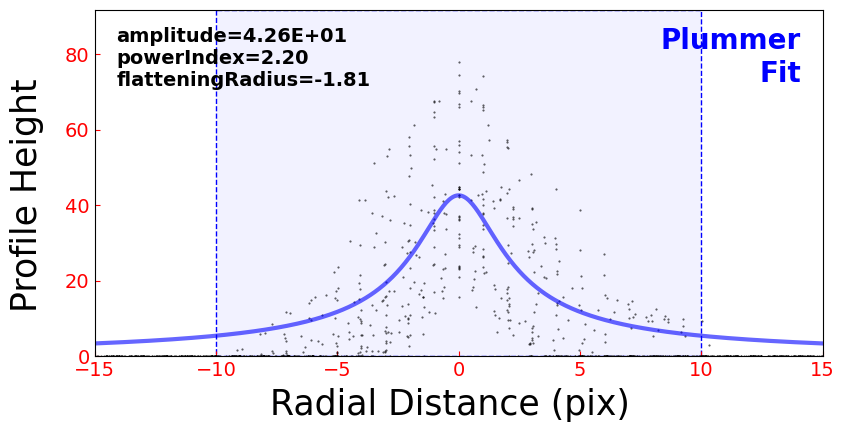

In [43]:
FitFunc = 'Plummer' #Plummer,Gaussian
FitDist = None
FitMeanProfile = False
BGDist = None
BGDegree = 0
BeamWidth = None

for FitFunc in ['Gaussian','Plummer']:
    Profile_Funs.Fit_Profile(filamentObj,FitFunc,FitDist,FitMeanProfile,BGDist,BGDegree,BeamWidth)
    
    for (name,error) in zip(filamentObj.radObj.profilefit.param_names,filamentObj.radObj.std_error): 
        print("The statistical uncertainty on the best-fit {} is {}".format(name,np.around(error,3)))

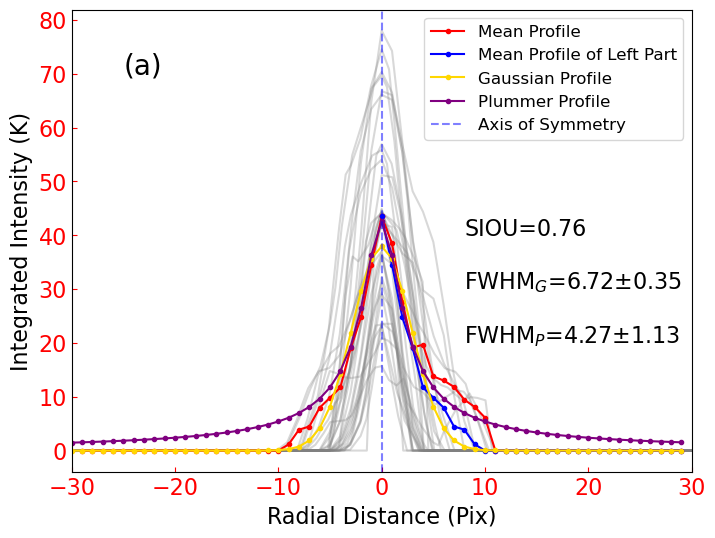

In [44]:
fontsize = 16
dictionary_cuts = filamentObj.dictionary_cuts

fig,(ax0)= plt.subplots(1,1, figsize=(8, 6))
for i in range(0,len(dictionary_cuts['distance'])):
    dists_i = dictionary_cuts['distance'][i][np.where(dictionary_cuts['profile'][i]!=0)]
    delta_dist = dists_i[-1]-dists_i[0]
    if delta_dist>filamentObj.EProfileLen:
        ax0.plot(dictionary_cuts['distance'][i], dictionary_cuts['profile'][i],c='gray',alpha=0.3)

ax0.plot(filamentObj.axis_coords_left, filamentObj.mean_profile_left,c='r',marker='.',alpha=1,label='Mean Profile')
ax0.plot(filamentObj.axis_coords_right, filamentObj.mean_profile_right,c='r',marker='.',alpha=1)
ax0.plot(filamentObj.axis_coords_right, filamentObj.mean_profile_left_r,c='b',marker='.',alpha=1,label='Mean Profile of Left Part')
ax0.plot(filamentObj.axis_coords, filamentObj.profile_fited_G,c='gold',marker='.',alpha=1,label='Gaussian Profile')
ax0.plot(filamentObj.axis_coords, filamentObj.profile_fited_P,c='purple',marker='.',alpha=1,label='Plummer Profile')

ax0.axvline(0, color='b', linestyle='dashed',alpha=0.5,label='Axis of Symmetry')
ax0.text(-25,70,'(a)',color='black',fontsize=fontsize+4)
ax0.text(8,40,'SIOU={}'.format(filamentObj.profile_IOU),color='black',fontsize=fontsize)
ax0.text(8,30,'FWHM$_G$={}$\pm${}'.format(filamentObj.FWHM_G,filamentObj.FWHM_error_G),color='black',fontsize=fontsize)
ax0.text(8,20,'FWHM$_P$={}$\pm${}'.format(filamentObj.FWHM_P,filamentObj.FWHM_error_P),color='black',fontsize=fontsize)
plt.xlim(-30,30)
plt.xlabel("Radial Distance (Pix)",fontsize=fontsize)
plt.ylabel(r"Integrated Intensity (K)",fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.legend(fontsize=fontsize-4)
# plt.savefig('../Images/Intensity_Profile_Fited.pdf', format='pdf', dpi=1000)
plt.show()

### If you have any questions about this tutorial, please open an issue on github, or email the author. (yujiang@pmo.ac.cn)